In [1]:
%matplotlib notebook
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn import metrics
from sklearn.metrics import classification_report, f1_score, confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, auc
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
import numpy as np
from sklearn.model_selection import train_test_split

trainPath = '../data/hateval2019_en_train_clean.csv'
testPath = '../data/hateval2019_en_test_clean.csv'

trainSet = pd.read_csv(trainPath)
testSet = pd.read_csv(testPath)

hateSet = trainSet[trainSet['HS']==1]

print(trainSet.shape)
print(hateSet.shape)

print(testSet.shape)

(9000, 6)
(3783, 6)
(3000, 6)


In [2]:
def fitting(x,y):
    sgd = SGDClassifier()

    %time sgd.fit(x, y)
    
    return sgd

def classify(x,y, sgd):
    y_pred_class_sgd = sgd.predict(x)

    sgd_acc = metrics.accuracy_score(y, y_pred_class_sgd)

    print(classification_report(y, y_pred_class_sgd, labels=[0,1]))
    
    f1 = f1_score(y, y_pred_class_sgd)
    
    print(f1)
    
    conf_matrix = confusion_matrix(y_true=y, y_pred=y_pred_class_sgd)

    fig, ax = plt.subplots(figsize=(7.5, 7.5))
    ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

    plt.xlabel('Predictions', fontsize=18)
    plt.ylabel('Actuals', fontsize=18)
    plt.title('Confusion Matrix', fontsize=18)
    plt.show()
    
    return y_pred_class_sgd, f1
    
    
def Metrics(x,y, sgd):
    
    score_roc = sgd.decision_function(y)
    fpr, tpr, thresholds = metrics.roc_curve(y, score_roc)
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    lw = 2
    
    fpr, tpr, thresholds = metrics.roc_curve(y, score_roc)
    roc_auc = auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
    plt.legend(loc='lower right')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

Wall time: 24 ms
              precision    recall  f1-score   support

           0       0.79      0.17      0.28      1740
           1       0.45      0.94      0.61      1260

    accuracy                           0.49      3000
   macro avg       0.62      0.55      0.44      3000
weighted avg       0.65      0.49      0.42      3000

0.6077774916301828


<IPython.core.display.Javascript object>


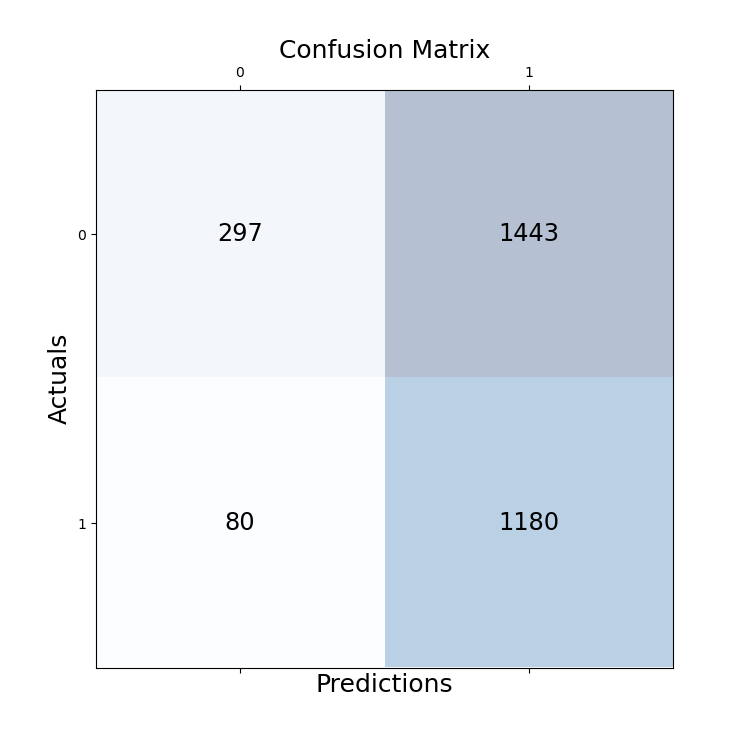

In [3]:
#Hate Score
vect = TfidfVectorizer(stop_words='english', ngram_range=(1, 1), min_df=3, max_df=0.5)

#x_train_dtm = vect.fit_transform(x)
#x_test_dtm = vect.transform(x_test)

x_train_dtm = vect.fit_transform(trainSet.text)
x_test_dtm = vect.transform(testSet.text)

sgd = fitting(x_train_dtm, trainSet.HS)
hs_pred, hs_F1 = classify(x_test_dtm, testSet.HS, sgd)
#Metrics(x_test_dtm, testSet.HS, sgd)

Wall time: 13 ms
              precision    recall  f1-score   support

           0       0.94      0.77      0.84      2471
           1       0.42      0.78      0.54       529

    accuracy                           0.77      3000
   macro avg       0.68      0.77      0.69      3000
weighted avg       0.85      0.77      0.79      3000

0.5430637738330045


<IPython.core.display.Javascript object>


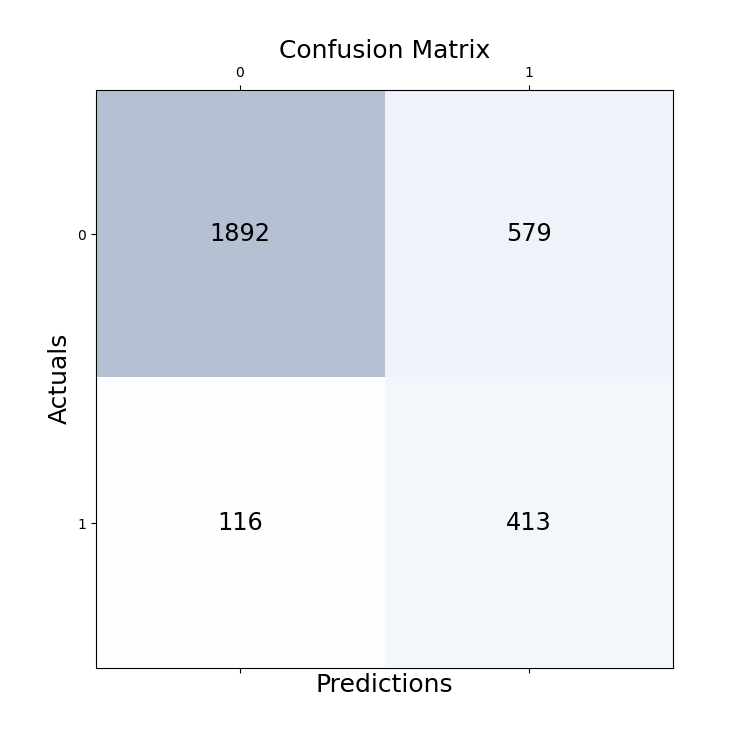

In [4]:
#Target Score
vect = TfidfVectorizer(stop_words='english', ngram_range=(1, 1), min_df=3, max_df=0.5)

#x_train_dtm = vect.fit_transform(hateSet.text)
x_train_dtm = vect.fit_transform(trainSet.text)
x_test_dtm = vect.transform(testSet.text)

lr = fitting(x_train_dtm, trainSet.TR)
tr_pred, tr_F1 = classify(x_test_dtm, testSet.TR, lr)
#Metrics(x_test_dtm, testSet.TR, lr)

Wall time: 13 ms
              precision    recall  f1-score   support

           0       0.84      0.77      0.80      2406
           1       0.30      0.40      0.34       594

    accuracy                           0.69      3000
   macro avg       0.57      0.58      0.57      3000
weighted avg       0.73      0.69      0.71      3000

0.34073013600572655


<IPython.core.display.Javascript object>


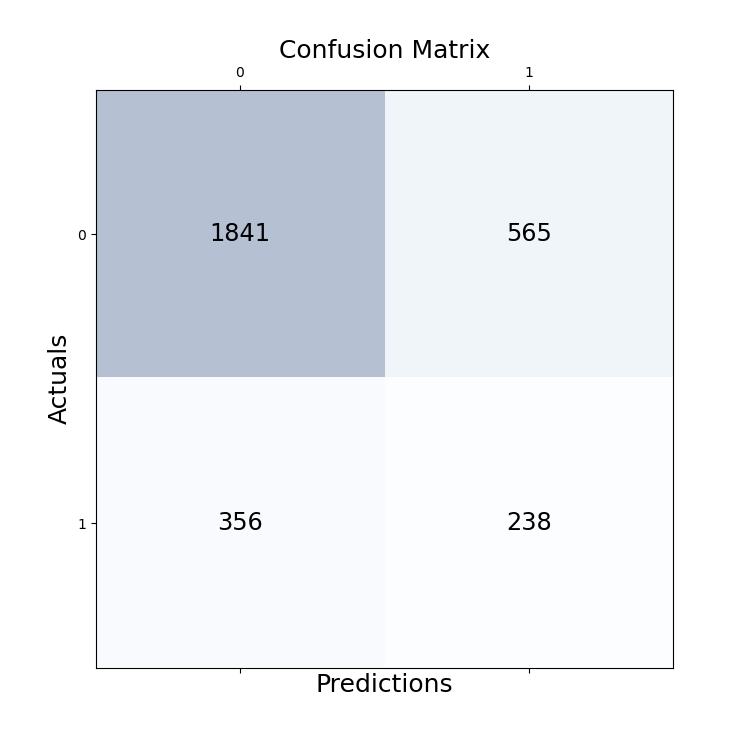

In [5]:
#Aggressive Score
vect = TfidfVectorizer(stop_words='english', ngram_range=(1, 1), min_df=3, max_df=0.5)

#x_train_dtm = vect.fit_transform(hateSet.text)
x_train_dtm = vect.fit_transform(trainSet.text)
x_test_dtm = vect.transform(testSet.text)

lr = fitting(x_train_dtm, trainSet.AG)
ag_pred, ag_F1 = classify(x_test_dtm, testSet.AG, lr)
#Metrics(x_test_dtm, testSet.AG, lr)

In [6]:
y_true = np.empty((0,3), int)
y_pred = np.empty((0,3), int)
for i in range(2999):
    y_true = np.append(y_true, [[testSet.HS[i], testSet.TR[i], testSet.HS[i]]], axis = 0)
    y_pred = np.append(y_pred, [[hs_pred[i], tr_pred[i], ag_pred[i]]], axis = 0)

#Overall F1-Score
overall_F1 = (hs_F1 + tr_F1 + ag_F1) / 3
#Exact Match Ratio
EMR = np.all((y_pred == y_true), axis=1).mean()

print("Overall F1 Score: %f" % overall_F1)
print("Exact Match Ratio: %f" % EMR)

Overall F1 Score: 0.497190
Exact Match Ratio: 0.206402


In [7]:
'''from sklearn.model_selection import GridSearchCV
c_space = np.logspace(-5,8,15)
param_grid = {'C': c_space,
             'max_iter' : [10000, 100000],
             'penalty': ['l1', 'l2']}


if __name__ == "__main__":
    logreg = LogisticRegression()
    logreg_cv = GridSearchCV(logreg, param_grid,n_jobs=4,verbose=1, scoring='f1')
    logreg_cv.fit(x_train_dtm, trainSet.HS)
    
    print("LR Parameter: {}".format(logreg_cv.best_params_))
    print("LR Accuracy: {}".format(logreg_cv.best_score_))'''

'from sklearn.model_selection import GridSearchCV\nc_space = np.logspace(-5,8,15)\nparam_grid = {\'C\': c_space,\n             \'max_iter\' : [10000, 100000],\n             \'penalty\': [\'l1\', \'l2\']}\n\n\nif __name__ == "__main__":\n    logreg = LogisticRegression()\n    logreg_cv = GridSearchCV(logreg, param_grid,n_jobs=4,verbose=1, scoring=\'f1\')\n    logreg_cv.fit(x_train_dtm, trainSet.HS)\n    \n    print("LR Parameter: {}".format(logreg_cv.best_params_))\n    print("LR Accuracy: {}".format(logreg_cv.best_score_))'

In [8]:
#x, x_test, y, y_test = train_test_split(trainSet.text,trainSet.HS, random_state=1)